# Python時系列データ分析入門（演習問題解答）

## 問題
### 配布したデータ”AirPassengers.csv”を用いて以下の 問題を実装せよ     

### ①csvファイルをDataFrame型の変数として読み込み、デー タの数を確認せよ

In [23]:
import pandas as pd

df = pd.read_csv('AirPassengers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [24]:
df = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True, dtype=float)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null float64
dtypes: float64(1)
memory usage: 2.2 KB


In [25]:
df.shape

(144, 1)

### A. 144

***
### ②データを可視化し、定常性があるか確認せよ

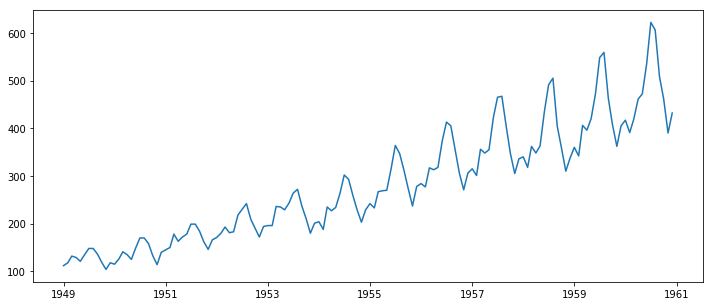

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df)
plt.show()

### A. 定常性は確認できない

***
### ③データの偏自己相関係数を求め、データを可視化せよ

In [31]:
import statsmodels.api as sm

train = df.loc[:'1958-12-1', ['#Passengers']]
test = df['#Passengers']


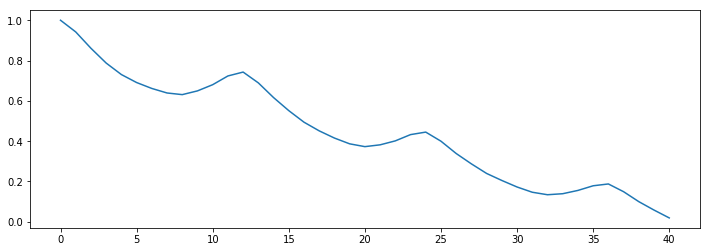

In [32]:
# acf
# acf : 自己相関
acf = sm.tsa.stattools.acf(train, nlags=40)
fig = plt.figure(figsize=(12, 4))
plt.plot(acf)
plt.show()

[ 1.          0.94952531 -0.31253254  0.19191073  0.12953656  0.30026506
 -0.04597595  0.13935595  0.19029378  0.59915247  0.28553776  0.83298019
  0.53360822 -0.81800596 -0.40215536  0.08989486 -0.16088691 -0.02760234
 -0.01271437  0.27176203 -0.12271096  0.15365169  0.27022852  0.21598497
 -0.08304693 -0.23150016 -0.29003295  0.04806802  0.04395919  0.01783825
 -0.03265652  0.30450766  0.14940021 -0.07606374  0.26681111 -0.04424308
  0.21281228 -0.0231988  -0.28334686  0.18843802  0.26183636]


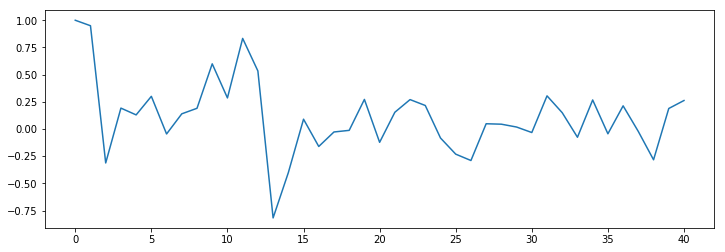

In [33]:

# pacf
# p:pertial 偏
# acf : 自己相関
pacf = sm.tsa.stattools.pacf(train, nlags=40, method='ols') # ols : 最小二乗法


fig = plt.figure(figsize=(12, 4))
plt.plot(pacf)
print(pacf)
plt.show()

***
### ④データに周期性があるか確認せよ。また、確認できる 場合はどれくらいの周期か考察せよ

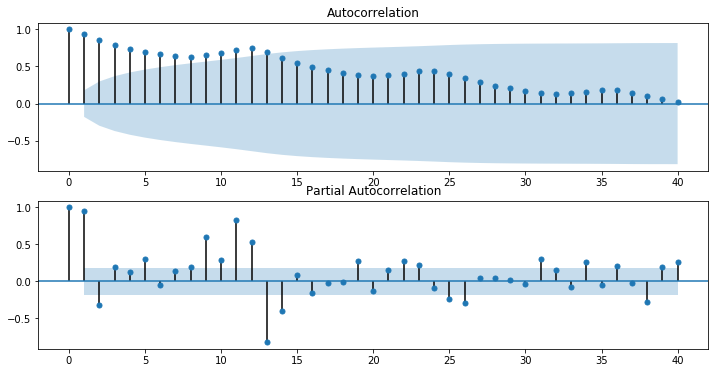

In [6]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=40, ax=ax2, method='ols')
plt.show()

In [7]:
train_dif = train.diff()
train_dif = train_dif.dropna()

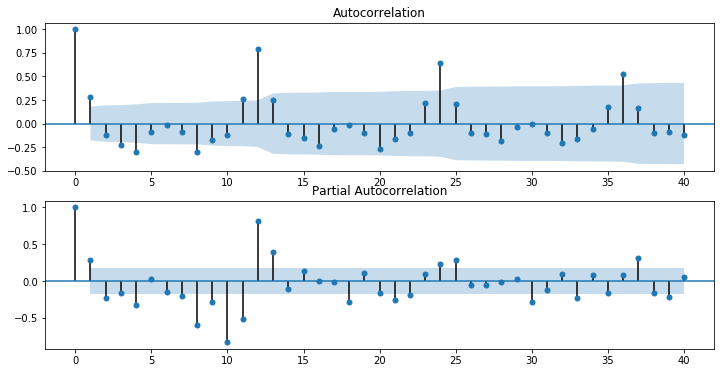

In [8]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_dif, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_dif, lags=40, ax=ax2, method='ols')
plt.show()

### A. 周期12

***
### ⑤今日学んだ時系列モデルの枠組みだと、どのモデルが 一番有効であるか考察せよ

### A. 非定常性データであること、周期性があることからSARIMAモデルが適していると考えられる

***
### ⑥講義のプログラムを参考にして、SARIMAモデルの中で当てはまりのよさそうな次数をAICを用いて求めよ

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


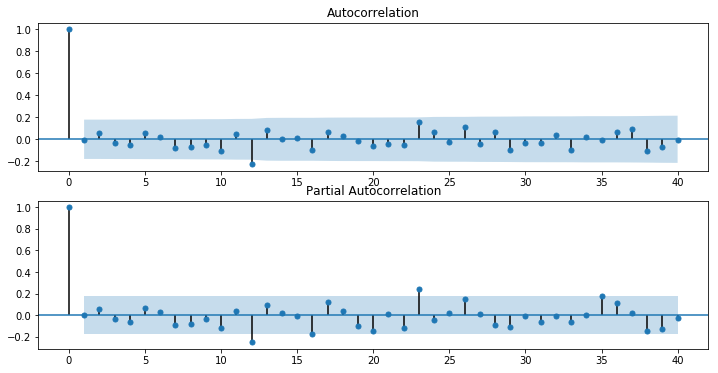

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train, freq='MS', order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
resid = sarima.resid
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.show()

In [10]:
p_max, d_max, q_max = 2, 2, 2
max_sp, max_sd, max_sq = 1, 1, 1
pattern = p_max
for mx in [d_max, q_max, max_sp, max_sd, max_sq]:
    pattern *= mx + 1
result = pd.DataFrame(index=range(pattern), columns=['model', 'aic'])

num = 0
for p in range(1, p_max + 1):
    for d in range(0, d_max + 1):
        for q in range(0, q_max + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        try:
                            sarima = SARIMAX(
                            train, freq='MS', order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                            ).fit(method='bfgs', maxiter=300, disp=False)
                            
                            result.iloc[num]["model"] = 'order=({},{},{}), season=({},{},{})'.format(p, d, q, sp, sd, sq)
                            result.iloc[num]["aic"] = sarima.aic
                            num = num + 1
                        except:
                            pass
result[result.aic == min(result.aic)]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


,model,aic
67,"order=(1,2,2), season=(0,1,1)",697.902


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


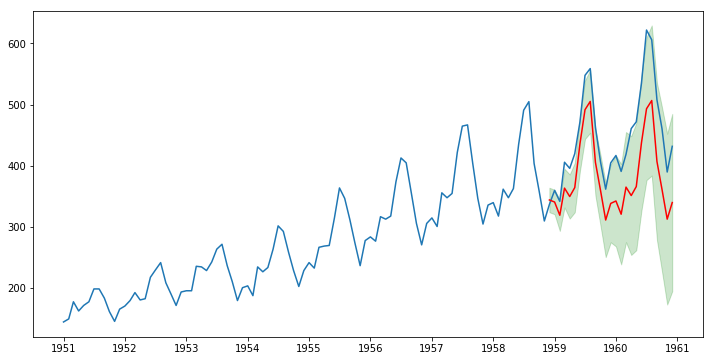

In [11]:
sarima = SARIMAX(train, freq='MS', order=(1, 2, 2), seasonal_order=(0, 1, 1, 12)).fit()
predict = sarima.predict('1958-12', '1960-12')
predict_dy = sarima.get_prediction('1958-12','1960-12')
predict_dy_ci = predict_dy.conf_int(alpha=0.05)

plt.figure(figsize=(12,6))
plt.plot(test[test.index.year > 1950])
plt.plot(predict,"r")
plt.fill_between(predict_dy_ci.index, predict_dy_ci.iloc[:, 0], 
                 predict_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.show()

***
## おまけ: Google Trendsから取得したCSVデータを分析

In [34]:
import pandas as pd

df = pd.read_csv('silent_siren.csv')
df.head()

FileNotFoundError: [Errno 2] File b'silent_siren.csv' does not exist: b'silent_siren.csv'

In [ ]:
df = pd.read_csv('silent_siren.csv', header=1, parse_dates=True) # header=1として0行目を無視
df.columns = ['week', '#searches'] # 列名を変更
df = df.set_index('week').astype(float) # 'week'をインデックスに割り当て、データ型をfloatに
df.head()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df)
plt.show()